In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install tslearn
from statsmodels.tsa.seasonal import seasonal_decompose # sezonluğu çıxarıb ona baxmaq
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm # adfuller test üçün/stationaritynin yoxlanması
import plotly.express as px 
import seaborn as sns
import itertools # AIC BIC iterasyaları üçün
import plotly.graph_objects as go #figure üçün dashboardda
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from neuralprophet import NeuralProphet

In [3]:
df= pd.read_excel("C://Users//Hp//Desktop//KapitalBank_Case/Case2_Dataset.xlsx")

In [4]:
df

Date Value
0    2020-01-01  5027
1    2020-01-02  6557
2    2020-01-03  6561
3    2020-01-04  5816
4    2020-01-05  4769
...         ...   ...
1132 2023-02-05     ?
1133 2023-02-06     ?
1134 2023-02-07     ?
1135 2023-02-08     ?
1136 2023-02-09     ?

[1137 rows x 2 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1137 non-null   datetime64[ns]
 1   Value   1137 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 17.9+ KB


In [6]:
# 
df['Date'].value_counts()

2022-02-07    2
2020-01-01    1
2022-02-02    1
2022-01-31    1
2022-01-30    1
             ..
2021-01-19    1
2021-01-20    1
2021-01-21    1
2021-01-22    1
2023-02-09    1
Name: Date, Length: 1136, dtype: int64

In [7]:
df[df["Date"]=='2022-02-07']

Date  Value
768 2022-02-07  30833
769 2022-02-07  32562

## Data Preprocessing

In [8]:
df['Value'][768]=(df['Value'][768]+df['Value'][769])/2;

In [9]:
df.index

RangeIndex(start=0, stop=1137, step=1)

In [10]:
df = df.drop(df.index[769]).reset_index(drop=True)
#df['Value'] = df['Value'].drop(df.index[769]).reset_index(drop=True)


In [11]:
df['Value'][769]

28355

In [12]:
df.isnull().sum()

Date     0
Value    0
dtype: int64

In [13]:
df[df["Value"]=="NaN"]

Empty DataFrame
Columns: [Date, Value]
Index: []

In [14]:
df['Value']=df['Value'].replace('?','')

In [15]:
df['Value']= pd.to_numeric(df['Value'], errors = 'coerce') # ıstenılen eroru gormezden gel 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1136 non-null   datetime64[ns]
 1   Value   1096 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.9 KB


In [17]:
df_train=df.iloc[:1096]
df_train.head()

Date   Value
0 2020-01-01  5027.0
1 2020-01-02  6557.0
2 2020-01-03  6561.0
3 2020-01-04  5816.0
4 2020-01-05  4769.0

In [18]:
df_train = df_train.set_index('Date').asfreq('D')

In [19]:
df_train

Value
Date               
2020-01-01   5027.0
2020-01-02   6557.0
2020-01-03   6561.0
2020-01-04   5816.0
2020-01-05   4769.0
...             ...
2022-12-27  29943.0
2022-12-28  29830.0
2022-12-29  30127.0
2022-12-30  34513.0
2022-12-31  12153.0

[1096 rows x 1 columns]

In [20]:
df_test=df.iloc[1095:]

# EDA (Exploratory Data Analysis)

In [21]:
go.Figure([go.Scatter(x=df["Date"], y=df['Value'])]).show()


In [22]:
fig = px.line(df, x='Date', y='Value', title='Time Series')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

## Based on above given plot I can not judge stationarity of the data. That's why I need to visualize rolling mean and standart deviation.

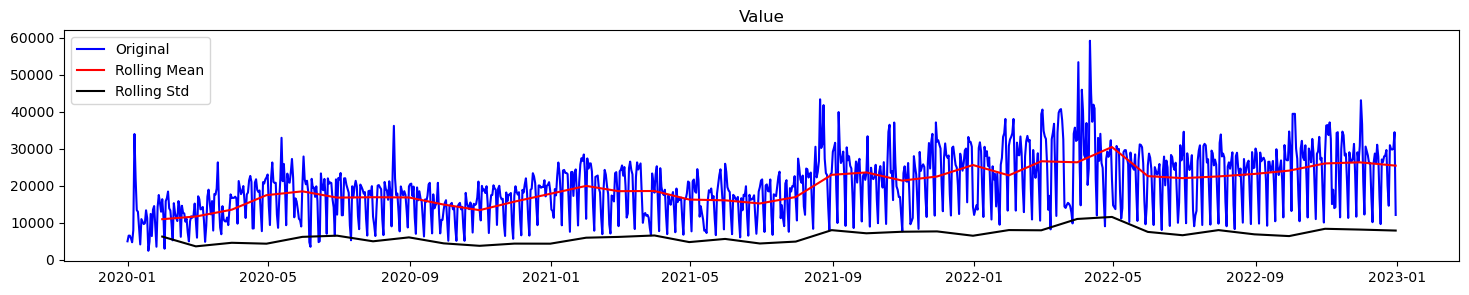

In [23]:
# Resample the entire dataset by month
rollmean = df_train.resample(rule='M').mean()
rollstd = df_train.resample(rule='M').std()
# Plot time series based on mean, std
for name in df_train.columns:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(df_train[name], color='blue', label='Original')
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

In [24]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(df_train['Value'])

Results of Dickey-Fuller Test:
Test Statistic                   -3.033531
p-value                           0.031879
#Lags Used                       21.000000
Number of Observations Used    1074.000000
Critical Value (1%)              -3.436453
Critical Value (5%)              -2.864235
Critical Value (10%)             -2.568205
dtype: float64


## Firstly, I checked the result through visual, I realize that from graph it is stationary data which means that rolling mean and standart deviation are roughly constant through given timeframe. Then in order to provide best decision it is needed to prove it statistically. I applied Dickey Fuller test and according to results it is stationary data since it is below 0.05 

In [25]:
decomposition = seasonal_decompose(df_train['Value'], model='multiplicative', period = 5)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

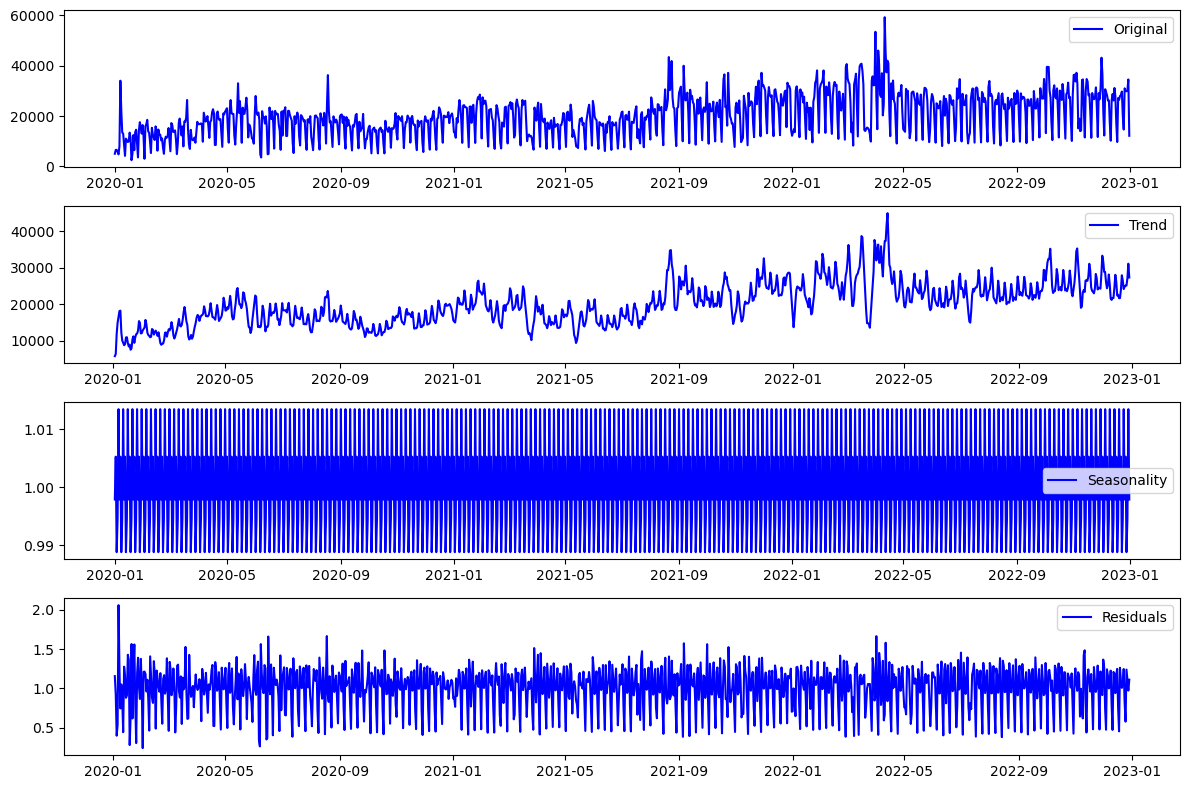

In [26]:
# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_train['Value'], label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")

plt.legend(loc='best')
plt.tight_layout()

In [27]:
# From graph I saw the trend roughly (4 months in each step). So I decided to check the residuals, std and variances
may_2020 = residual['05-2020']
sep_2020 = residual['09-2020']
jan_2021 = residual['01-2021']
may_2021 = residual['05-2021']
sep_2021 = residual['09-2021']
jan_2022 = residual['01-2022']
may_2022 = residual['05-2022']
sep_2022 = residual['09-2022']
print(f" may 2020 mean is {np.mean(may_2020)}, std {np.std(may_2020)}, variance: {np.var(may_2020)}")
print(f" sep 2020 mean is {np.mean(sep_2020)}, std {np.std(sep_2020)}, variance: {np.var(sep_2020)}")
print(f" jan 2021 mean is {np.mean(jan_2021)}, std {np.std(jan_2021)}, variance: {np.var(jan_2021)}")
print(f" may 2021 mean is {np.mean(may_2021)}, std {np.std(may_2021)}, variance: {np.var(may_2021)}")
print(f" sep 2021 mean is {np.mean(sep_2021)}, std {np.std(sep_2021)}, variance: {np.var(sep_2021)}")
print(f" jan 2022 mean is {np.mean(jan_2022)}, std {np.std(jan_2022)}, variance: {np.var(jan_2022)}")
print(f" may 2022 mean is {np.mean(may_2022)}, std {np.std(may_2022)}, variance: {np.var(may_2022)}")
print(f" sep 2022 mean is {np.mean(sep_2022)}, std {np.std(sep_2022)}, variance: {np.var(sep_2022)}")

 may 2020 mean is 0.9796106448674231, std 0.24851240150452145, variance: 0.061758413701544466
 sep 2020 mean is 0.9966422234445506, std 0.2538691100612628, variance: 0.06444952504329755
 jan 2021 mean is 0.9808564453620207, std 0.25415457987776663, variance: 0.06459455047284407
 may 2021 mean is 0.9776692622836138, std 0.2516437609865208, variance: 0.06332458244344122
 sep 2021 mean is 1.0020754168321906, std 0.28420309608156635, variance: 0.08077139982234804
 jan 2022 mean is 0.9801663436920621, std 0.26284311457058895, variance: 0.06908650287716776
 may 2022 mean is 0.9703121822333313, std 0.26134516436569255, variance: 0.06830129493733085
 sep 2022 mean is 1.0120068090574097, std 0.26683485623971653, variance: 0.07120084050447019


In [28]:
# extract prices at lag 1
c = df_train.rename(columns={'Value': 'no_lag'})
df2 = pd.DataFrame(c['no_lag'])
df2['lag1'] = df2.shift(periods = 1)
df2['lag1'][0]=np.nan
df2.head()

no_lag    lag1
Date                      
2020-01-01  5027.0     NaN
2020-01-02  6557.0  5027.0
2020-01-03  6561.0  6557.0
2020-01-04  5816.0  6561.0
2020-01-05  4769.0  5816.0

In [29]:
# View the correlation between the data
df2.corr()

no_lag      lag1
no_lag  1.000000  0.541735
lag1    0.541735  1.000000

<Axes: xlabel='Date'>

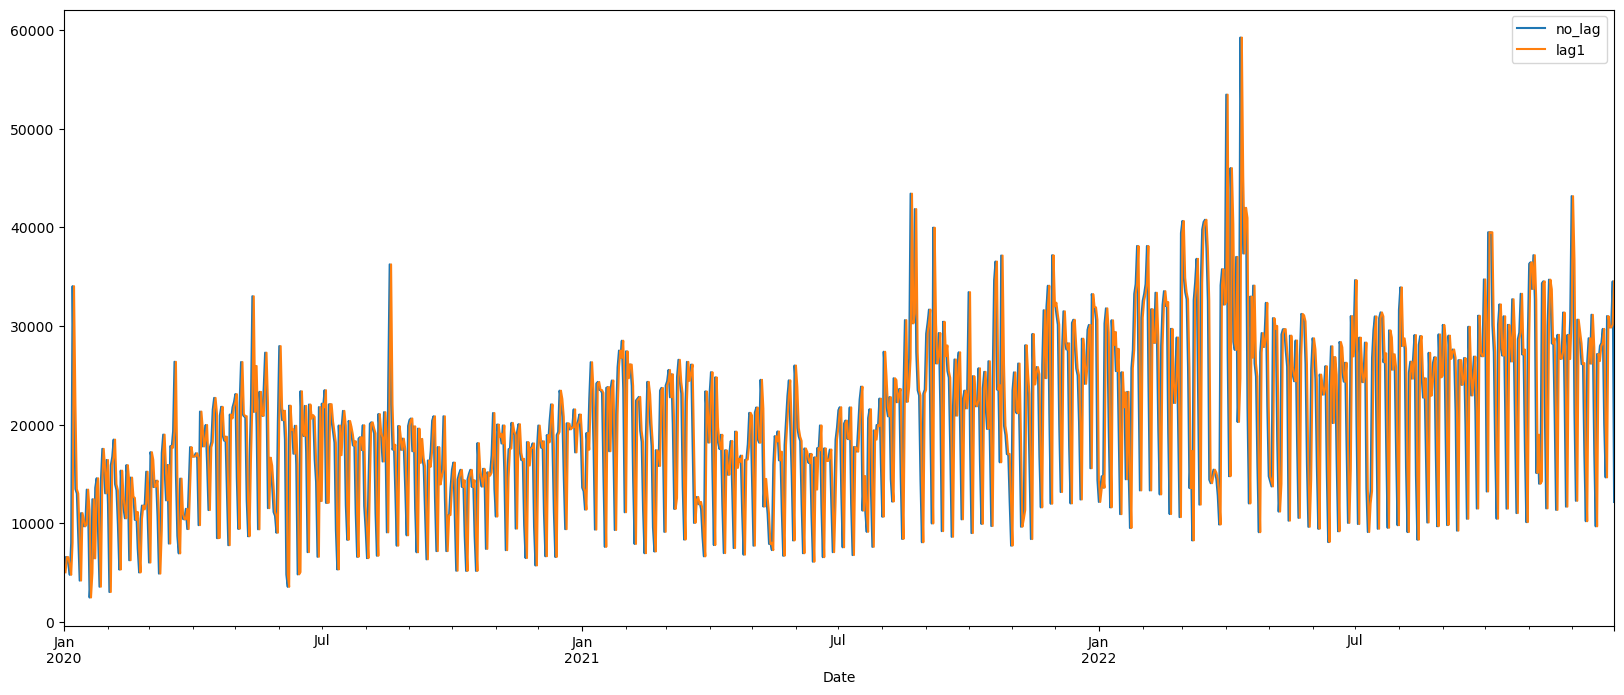

In [30]:
# dashboarda çevir

df2.plot(figsize = (20, 8))

In [31]:
# extract prices at lag 2
df2['lag_2'] = df2['no_lag'].shift(periods = 2)
df2.head()

no_lag    lag1   lag_2
Date                              
2020-01-01  5027.0     NaN     NaN
2020-01-02  6557.0  5027.0     NaN
2020-01-03  6561.0  6557.0  5027.0
2020-01-04  5816.0  6561.0  6557.0
2020-01-05  4769.0  5816.0  6561.0

In [32]:
df2.corr()

no_lag      lag1     lag_2
no_lag  1.000000  0.541735  0.238242
lag1    0.541735  1.000000  0.544325
lag_2   0.238242  0.544325  1.000000

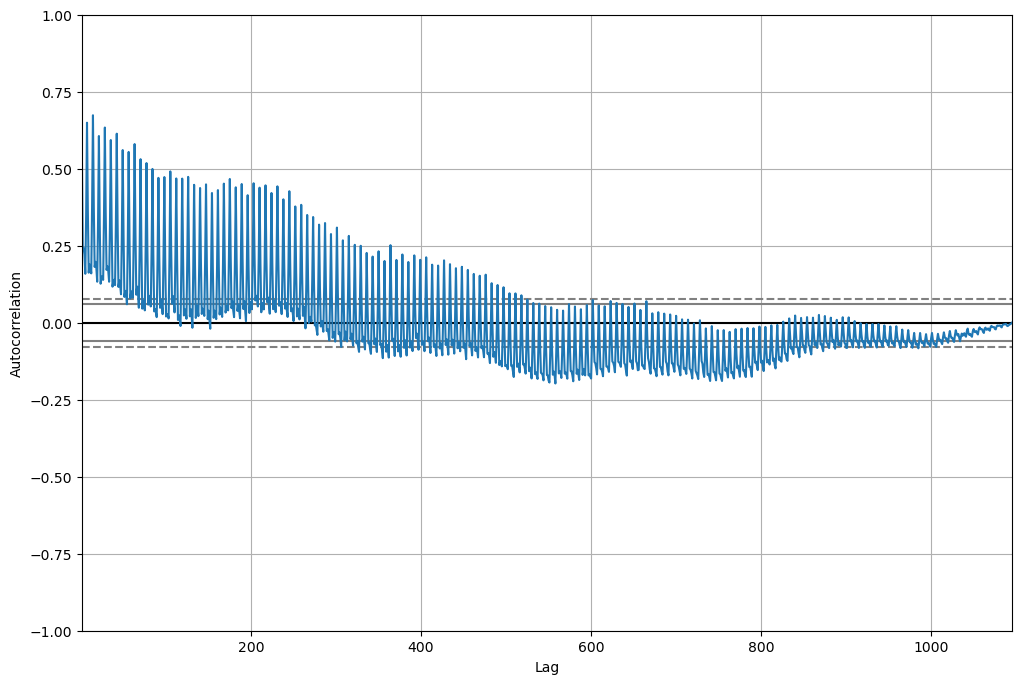

In [33]:
fig = plt.figure(figsize = (12, 8))
pd.plotting.autocorrelation_plot(df2['lag1'].dropna())

plt.show()

In [34]:
df_n =df2['no_lag'].diff(periods = 1).dropna()
df_n

Date
2020-01-02     1530.0
2020-01-03        4.0
2020-01-04     -745.0
2020-01-05    -1047.0
2020-01-06     3249.0
               ...   
2022-12-27    -1052.0
2022-12-28     -113.0
2022-12-29      297.0
2022-12-30     4386.0
2022-12-31   -22360.0
Freq: D, Name: no_lag, Length: 1095, dtype: float64

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

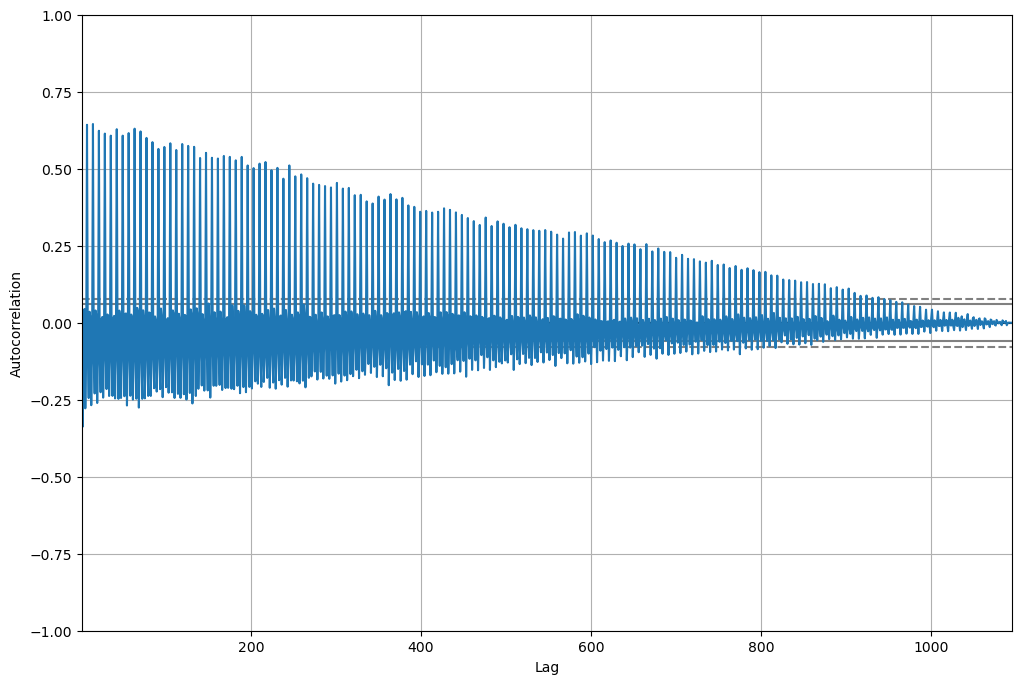

In [35]:
fig = plt.figure(figsize = (12, 8))
pd.plotting.autocorrelation_plot(df2['no_lag'].diff(periods = 1).dropna())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

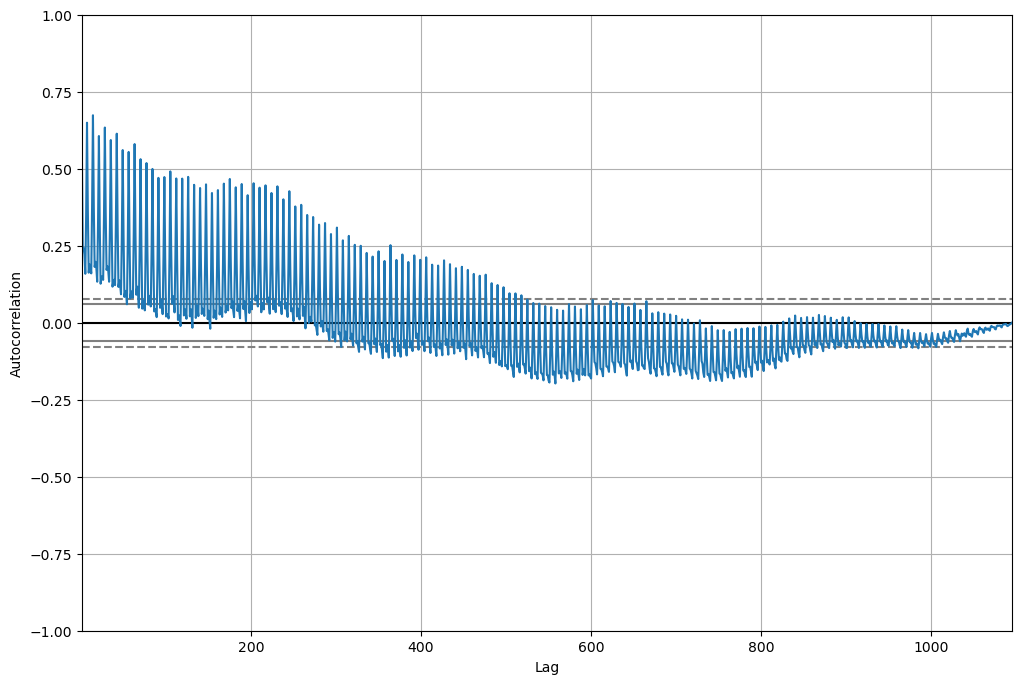

In [36]:
fig = plt.figure(figsize = (12, 8))
pd.plotting.autocorrelation_plot(df2['lag1'].dropna())

## Autocorrelation graph does not seem to be right in our case, mainly due to the reason that I am not able to see points where the line crosses 0 axis. This in turn lets me identify pdq terms which is for Autoregressor (AR), Integrated (I), Moving average (MA)

In [37]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_pacf = pacf(df_train, nlags=20, method='ols')

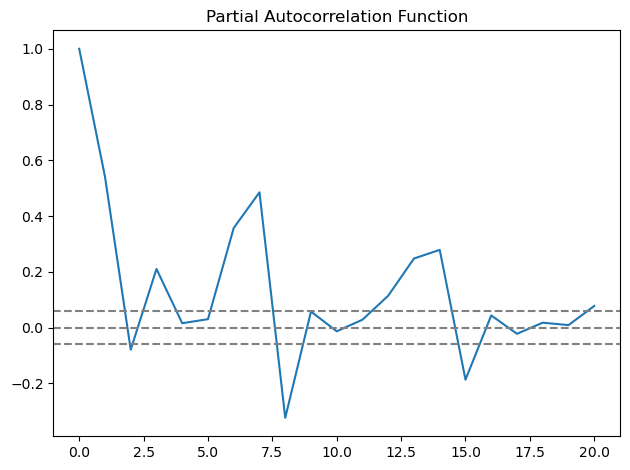

In [38]:
#Plot PACF:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_train)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#Plot PACF:



## As per the graph, it is quite visible that line crosses the axis at 2. Therefore, I need to utilize 2 1 0 for AR, MA, ARIMA.

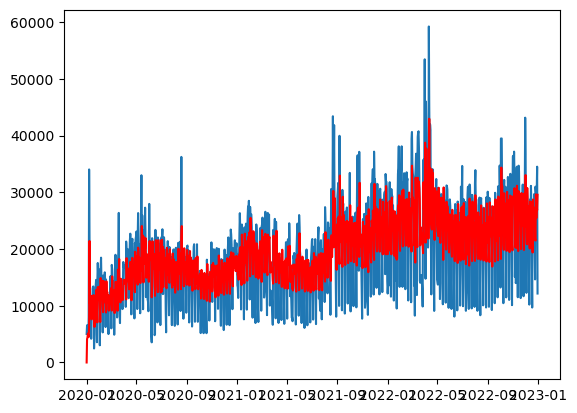

In [39]:
# Checking moving average
model = ARIMA(df_train, order=(0, 1, 2))  
results_MA = model.fit()  
plt.plot(df_train)
plt.plot(results_MA.fittedvalues, color='red');

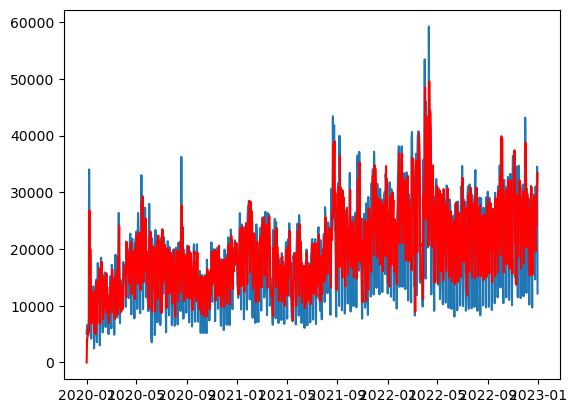

In [40]:
#AR Model
model = ARIMA(df_train, order=(2, 1, 0))  
results_AR = model.fit()  
plt.plot(df_train)
plt.plot(results_AR.fittedvalues, color='red');

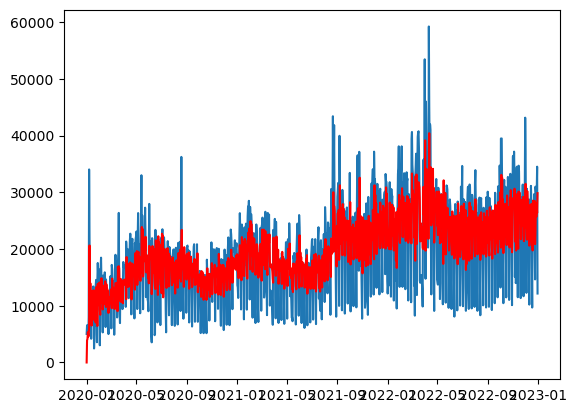

In [41]:
model = ARIMA(df_train, order=(2, 1, 2))  
results_ARIMA = model.fit()  
plt.plot(df_train)
plt.plot(results_ARIMA.fittedvalues, color='red')

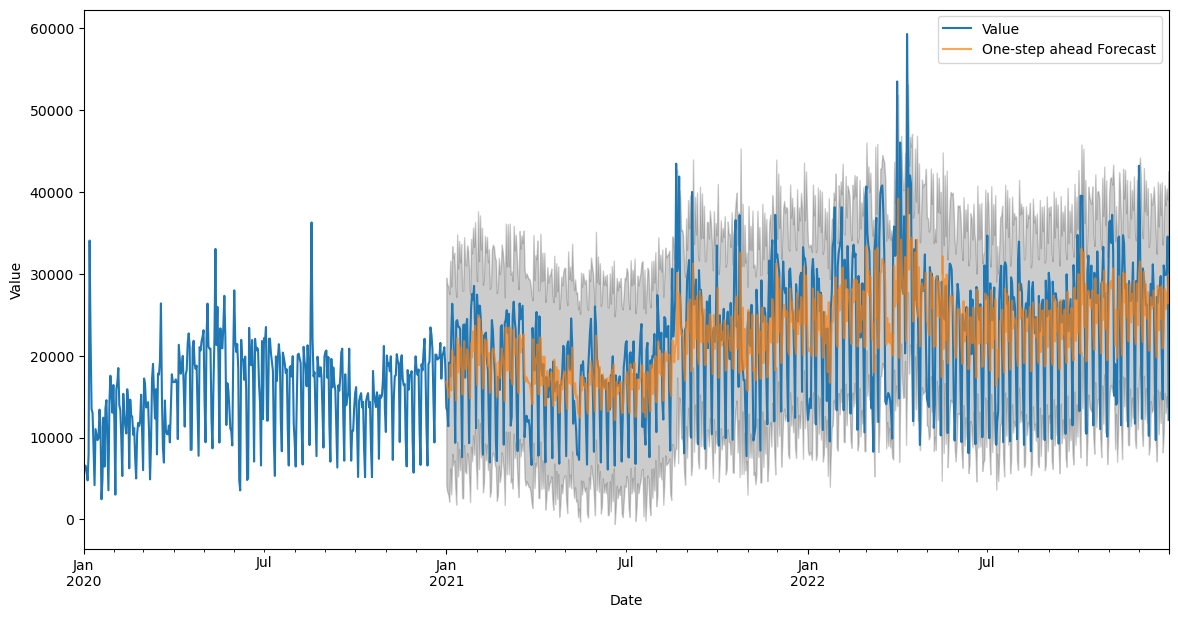

In [42]:
pred = results_ARIMA.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_train['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

In [43]:
y_forecasted = pred.predicted_mean
y_truth = df_train['2021-01-01':]
mse3 = ((y_forecasted.values - y_truth.values) ** 2).mean()
print('The RootMean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse3, 2))))

The RootMean Squared Error of our forecasts is 9561.35502949242


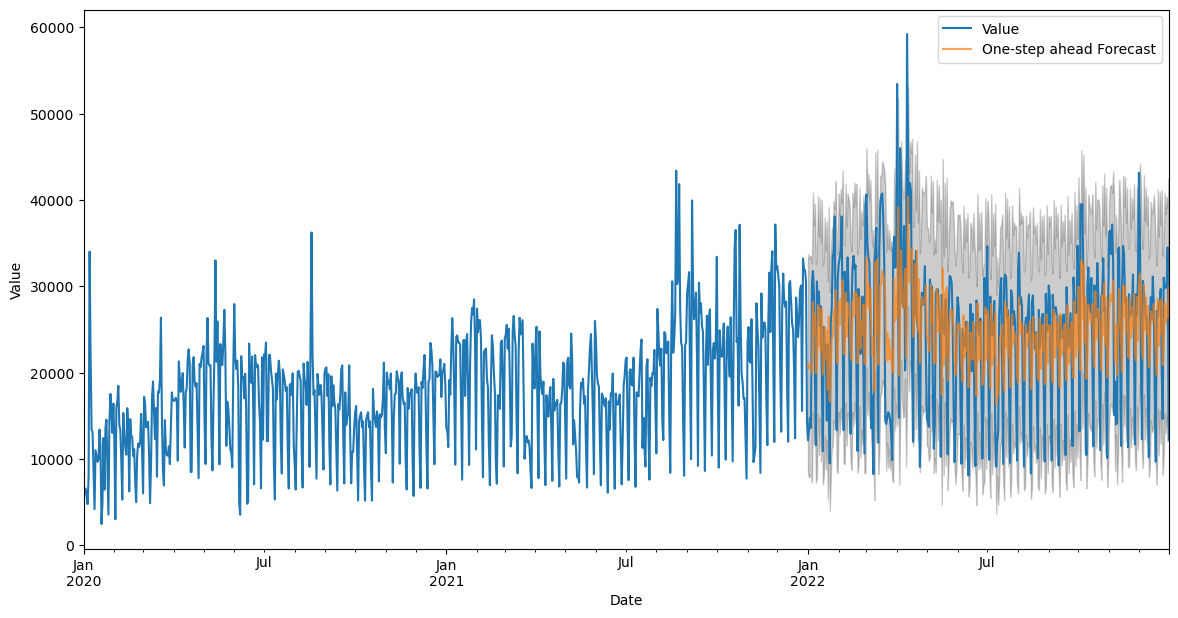

In [44]:
pred4 = results_ARIMA.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred4.conf_int()
ax = df_train['2020':].plot(label='observed')
pred4.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

## Based on the graph one can easily see that ARIMA was not able to capture the data points for 2022 starting from January. That's why I need to check the combinations of pdq terms from only 0 1. 2 can not be used as a lag number. Correlation results prove the same. 

In [45]:
y = df2['no_lag'].resample('MS').mean()

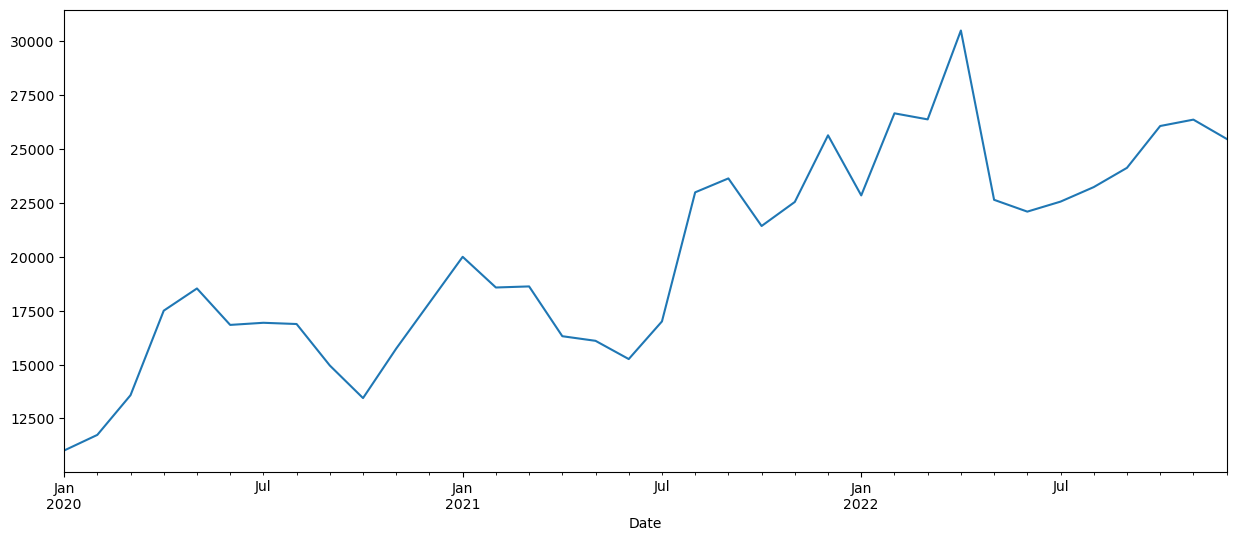

In [46]:
y.plot(figsize=(15, 6))
plt.show()

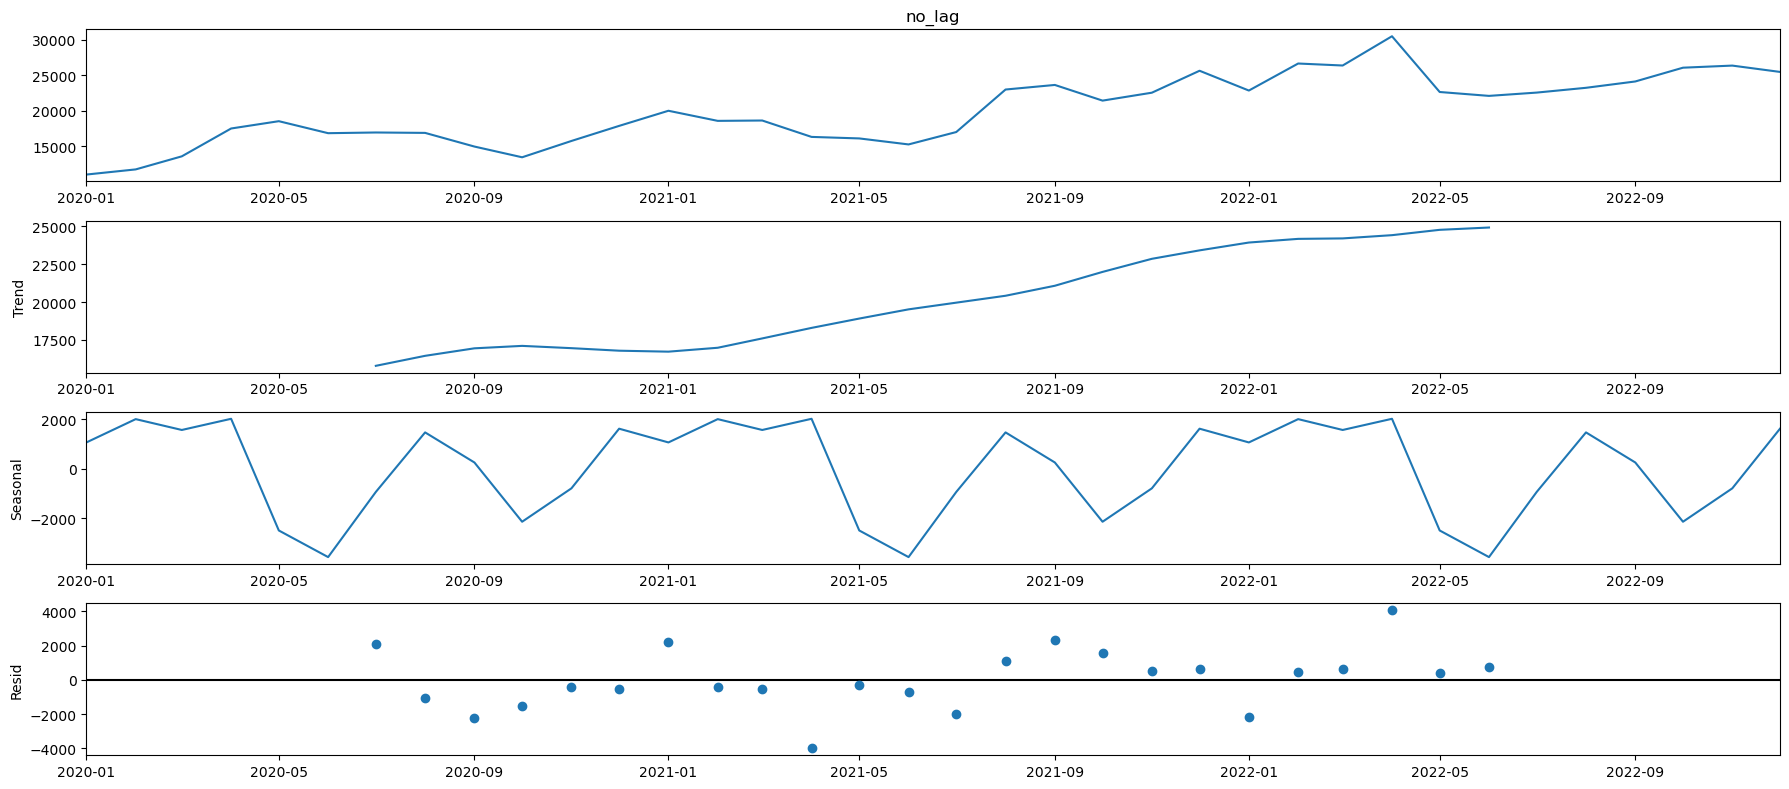

In [47]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Implementing ARIMA model

In [49]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [50]:

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:797.383389279802
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:511.0235498296886
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:468.27448810710155
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:236.61035481630876
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:476.9460380372128
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:457.7623828036145
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:247.21121788040728
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:223.86233868273595
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:754.4128365471893
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:489.3590506774349
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:436.87569331882366
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:204.5383017597868
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:469.50206970792243
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:487.4486747213681
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:244.57081051850727
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:195.68900313550833
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:630.7537807552278
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:414.8813975922499
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:426.

In [51]:
for i in range(64):
    a=i//32
    b=i%32//16
    c=i%16//8
    d=i%8//4
    e=i%4//2
    f=i%2
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=(a, b, c),
                                    seasonal_order=(d, e, f, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    table=results.summary().tables[1]
    my_data=table[-1][4]
    float_num = float(my_data.data)
    
    """ 
    if a==0 and b==0 and c==0 and d==1 and e==1 and f==0:
        continue
    if a==0 and b==0 and c==1 and d==1 and e==1 and f==0:
        continue
    if a==0 and b==1 and c==0 and d==0 and e==1 and f==1:
        continue
    if a==0 and b==1 and c==0 and d==1 and e==1 and f==0:
        continue
    if a==0 and b==1 and c==1 and d==0 and e==1 and f==1:
        continue
    if a==1 and b==1 and c==0 and d==1 and e==1 and f==0:
        continue 
    """ 
    if float_num>0.000 :
        
        print(float_num)
        print('pdq = ',a,b,c,'seasonal_pdq = ',d,e,f)
        print('AIC:{2}'.format(param, param_seasonal, results.aic))
        print(results.summary().tables[1])
        #results.plot_diagnostics(figsize=(16, 8))
        #plt.show()

0.19
pdq =  0 0 0 seasonal_pdq =  0 0 0
AIC:797.383389279802
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.247e+08   3.24e+08      1.311      0.190    -2.1e+08    1.06e+09
0.004
pdq =  0 0 0 seasonal_pdq =  0 1 0
AIC:468.27448810710155
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.608e+07   1.27e+07      2.843      0.004    1.12e+07    6.09e+07
0.01
pdq =  0 0 0 seasonal_pdq =  1 1 0
AIC:247.21121788040728
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3236      0.557      0.581      0.561      -0.768       1.415
sigma2      3.712e+07   1.45e+07      2.565      0.010    8.76e+06    6.55e+07
0.001
pdq =  0 0 1 sea

## I checked the table and choose the one which has ar ma and sigma2 value, which have reasonably better results  compared to other ARIMA values.  Additionally, AIC result is also low (244.2).  pdq =1,1,1 and seasonal_pdq = 0,0,0 also have ar, ma, sigma values, but does not seem to yield proper standardized residuals, histogram does not follow normal distribution. As a rule of thumb, standardized residuals are supposed to be in range of -2,2 (sometimes (-3,3) range is also acceptable). In our case, after applying 244.2 AIC results to the model, it is visible that standardized residuals are in range of (-2,2).

In [60]:
mod = sm.tsa.statespace.SARIMAX(df_train,
                                        order=(0,0,1),
                                        seasonal_order=(1,1,0,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results = mod.fit()

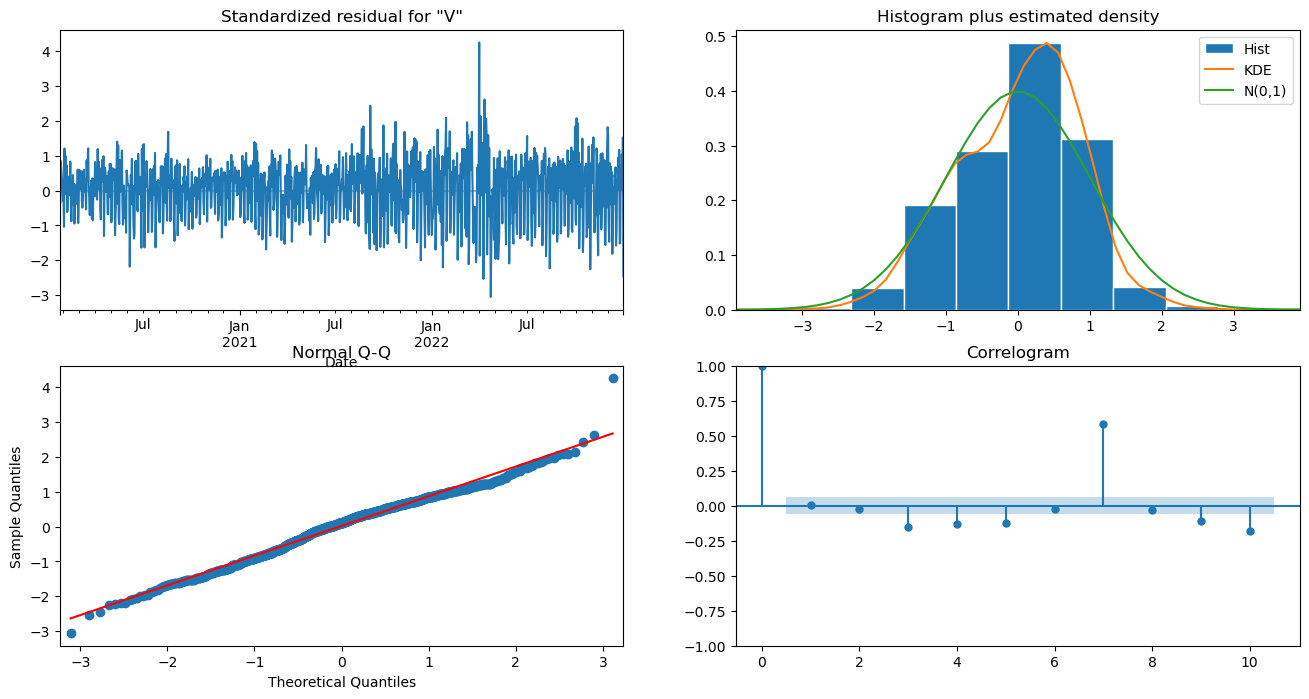

In [61]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

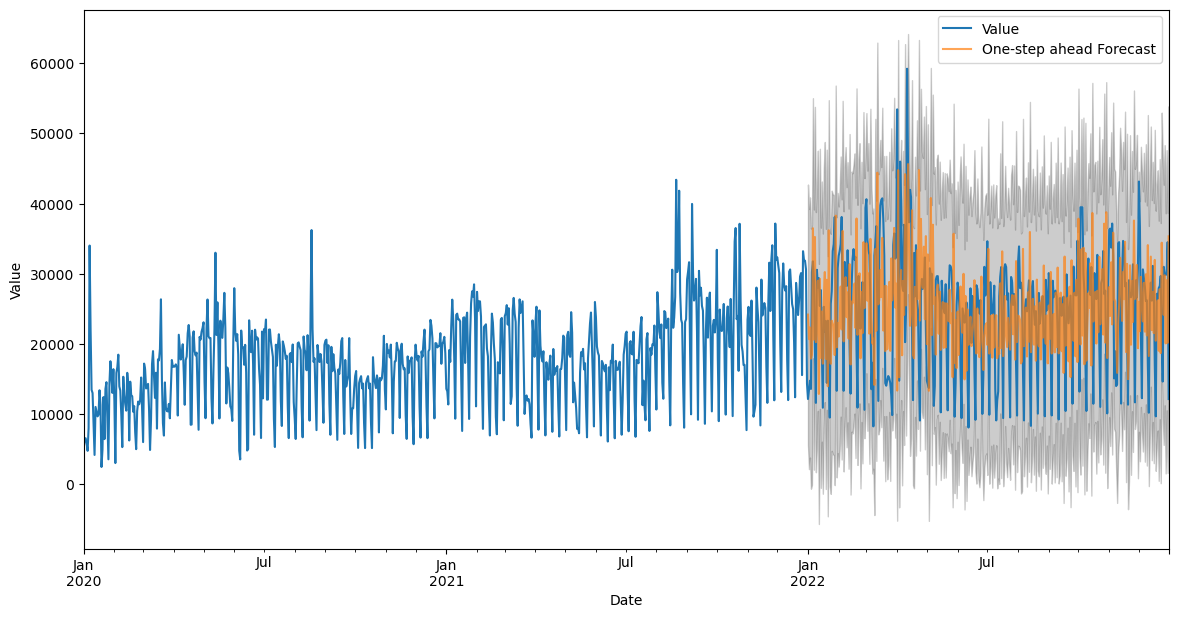

In [62]:
pred2 = results.get_prediction(start=pd.to_datetime('2022-01-01'),dynamic=False)
pred_ci = pred2.conf_int()
ax = df_train['2020':].plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

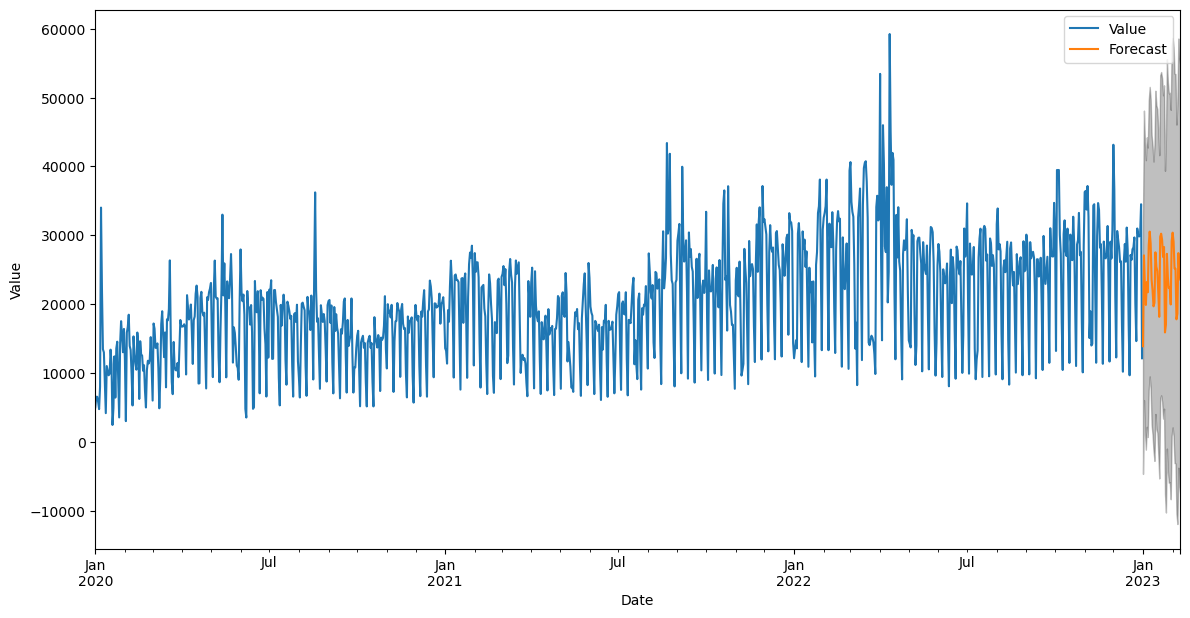

In [63]:
pred_uc = results.get_forecast(steps=40)
pred_ci = pred_uc.conf_int()
ax = df_train.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

## Based on the graph above, one can claim that forecast for Jan 2023 follows roughly the same trends of 2022, 2021.

In [64]:
predictions_ARIMA = results.predict(start='2023-01-01', end='2023-02-09').tolist()
predictions_ARIMA=np.round(predictions_ARIMA,0)

In [65]:
predictions_ARIMA

array([13899., 27095., 22571., 19896., 23219., 21733., 28572., 30539.,
       28822., 23560., 22032., 19694., 20203., 27534., 25428., 24822.,
       21644., 18169., 29790., 30239., 29329., 26861., 28306., 15903.,
       17034., 27313., 23992., 22346., 22436., 19960., 29177., 30390.,
       29074., 25202., 25152., 17809., 18627., 27424., 24714., 23591.])

## Implementing Prophet Model

In [66]:
df_train.reset_index(inplace = True)
df_train = df_train.rename(columns = {'Date':'ds', 'Value': 'y'})

In [67]:
df_train.columns

Index(['ds', 'y'], dtype='object')

In [68]:
m = NeuralProphet()
metrics = m.fit(df_train, freq="D")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 188
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (35) is too small than the required number for the learning rate finder (226). The results might not be optimal.


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [69]:
future = m.make_future_dataframe(df_train, periods=40)
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 35it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [70]:
forecasts_plot = m.plot(forecast)
forecasts_plot

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '4f7c366d-a159-40a9-96a4-764b0d845c7f',
              'x': array([datetime.datetime(2023, 1, 1, 0, 0),
                          datetime.datetime(2023, 1, 2, 0, 0),
                          datetime.datetime(2023, 1, 3, 0, 0),
                          datetime.datetime(2023, 1, 4, 0, 0),
                          datetime.datetime(2023, 1, 5, 0, 0),
                          datetime.datetime(2023, 1, 6, 0, 0),
                          datetime.datetime(2023, 1, 7, 0, 0),
                          datetime.datetime(2023, 1, 8, 0, 0),
                          datetime.datetime(2023, 1, 9, 0, 0),
                          datetime.datetime(2023, 1, 10, 0, 0),
                          datetime.datetime(2023, 1, 11, 0, 0),
                       

In [71]:
fig_comp = m.plot_components(forecast)
fig_comp

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'Trend',
              'showlegend': False,
              'type': 'scatter',
              'uid': '543d258b-93f8-4996-808b-6cfd692bb13c',
              'x': array([datetime.datetime(2023, 1, 1, 0, 0),
                          datetime.datetime(2023, 1, 2, 0, 0),
                          datetime.datetime(2023, 1, 3, 0, 0),
                          datetime.datetime(2023, 1, 4, 0, 0),
                          datetime.datetime(2023, 1, 5, 0, 0),
                          datetime.datetime(2023, 1, 6, 0, 0),
                          datetime.datetime(2023, 1, 7, 0, 0),
                          datetime.datetime(2023, 1, 8, 0, 0),
                          datetime.datetime(2023, 1, 9, 0, 0),
                          datetime.datetime(2023, 1, 10, 0, 0),
                          datetime.datetime(2023, 1, 11, 0, 0),
                          datetime

In [72]:
forecast = m.predict(future)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 35it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


ds     y         yhat1         trend  season_yearly  season_weekly
0  2023-01-01  None  14730.972656  25628.099609     -20.437778  -10876.689453
1  2023-01-02  None  28298.779297  25631.394531      -2.241177    2669.623535
2  2023-01-03  None  28570.056641  25634.689453      22.524618    2912.842773
3  2023-01-04  None  28363.667969  25637.984375      53.901581    2671.780518
4  2023-01-05  None  28632.482422  25641.281250      91.869568    2899.331787
5  2023-01-06  None  29537.398438  25644.576172     136.345062    3756.477539
6  2023-01-07  None  21801.687500  25647.871094     187.182465   -4033.365967
7  2023-01-08  None  15018.652344  25651.167969     244.174438  -10876.689453
8  2023-01-09  None  28631.136719  25654.460938     307.052399    2669.623535
9  2023-01-10  None  28946.089844  25657.757812     375.490234    2912.842773
10 2023-01-11  None  28781.939453  25661.050781     449.106262    2671.780518
11 2023-01-12  None  29091.144531  25664.347656     527.466370    2899.331787
12 2023-01-13  None  30034.207031  25667.642578     610.086975    3756.477539
13 2023-01-14  None  22334.011719  25670.937500     696.440857   -4033.365967
14 2023-01-15  None  15583.504883  25674.232422     785.961182  -10876.689453
15 2023-01-16  None  29225.195312  25677.527344     878.045654    2669.623535
16 2023-01-17  None  29565.728516  25680.822266     972.064026    2912.842773
17 2023-01-18  None  29423.261719  25684.119141    1067.361694    2671.780518
18 2023-01-19  None  29750.011719  25687.412109    1163.267334    2899.331787
19 2023-01-20  None  30706.285156  25690.708984    1259.099243    3756.477539
20 2023-01-21  None  23014.808594  25694.003906    1354.170288   -4033.365967
21 2023-01-22  None  16268.405273  25697.298828    1447.795898  -10876.689453
22 2023-01-23  None  29909.517578  25700.593750    1539.300903    2669.623535
23 2023-01-24  None  30244.757812  25703.890625    1628.023926    2912.842773
24 2023-01-25  None  30092.291016  25707.183594    1713.326050    2671.780518
25 2023-01-26  None  30404.406250  25710.480469    1794.595459    2899.331787
26 2023-01-27  None  31341.507812  25713.775391    1871.255371    3756.477539
27 2023-01-28  None  23626.470703  25717.070312    1942.766602   -4033.365967
28 2023-01-29  None  16852.312500  25720.367188    2008.636475  -10876.689453
29 2023-01-30  None  30461.705078  25723.660156    2068.420898    2669.623535
30 2023-01-31  None  30761.529297  25726.957031    2121.731201    2912.842773
31 2023-02-01  None  30570.267578  25730.251953    2168.235107    2671.780518
32 2023-02-02  None  30840.541016  25733.546875    2207.663574    2899.331787
33 2023-02-03  None  31733.132812  25736.841797    2239.812744    3756.477539
34 2023-02-04  None  23971.312500  25740.136719    2264.542969   -4033.365967
35 2023-02-05  None  17148.527344  25743.431641    2281.785400  -10876.689453
36 2023-02-06  None  30707.890625  25746.728516    2291.538574    2669.623535
37 2023-02-07  None  30956.738281  25750.021484    2293.873291    2912.842773
38 2023-02-08  None  30714.025391  25753.318359    2288.926514    2671.780518
39 2023-02-09  None  30932.851562  25756.613281    2276.906738    2899.331787

In [73]:
combine_models=pd.concat([pd.Series(predictions_ARIMA), forecast['yhat1']],axis=1);
combine_models.head(40)

0         yhat1
0   13899.0  14730.972656
1   27095.0  28298.779297
2   22571.0  28570.056641
3   19896.0  28363.667969
4   23219.0  28632.482422
5   21733.0  29537.398438
6   28572.0  21801.687500
7   30539.0  15018.652344
8   28822.0  28631.136719
9   23560.0  28946.089844
10  22032.0  28781.939453
11  19694.0  29091.144531
12  20203.0  30034.207031
13  27534.0  22334.011719
14  25428.0  15583.504883
15  24822.0  29225.195312
16  21644.0  29565.728516
17  18169.0  29423.261719
18  29790.0  29750.011719
19  30239.0  30706.285156
20  29329.0  23014.808594
21  26861.0  16268.405273
22  28306.0  29909.517578
23  15903.0  30244.757812
24  17034.0  30092.291016
25  27313.0  30404.406250
26  23992.0  31341.507812
27  22346.0  23626.470703
28  22436.0  16852.312500
29  19960.0  30461.705078
30  29177.0  30761.529297
31  30390.0  30570.267578
32  29074.0  30840.541016
33  25202.0  31733.132812
34  25152.0  23971.312500
35  17809.0  17148.527344
36  18627.0  30707.890625
37  27424.0  30956.738281
38  24714.0  30714.025391
39  23591.0  30932.851562

In [74]:
combine_models.columns = ["predictions_ARIMA","predictions_Prophet"]
combine_models.head(40)

predictions_ARIMA  predictions_Prophet
0             13899.0         14730.972656
1             27095.0         28298.779297
2             22571.0         28570.056641
3             19896.0         28363.667969
4             23219.0         28632.482422
5             21733.0         29537.398438
6             28572.0         21801.687500
7             30539.0         15018.652344
8             28822.0         28631.136719
9             23560.0         28946.089844
10            22032.0         28781.939453
11            19694.0         29091.144531
12            20203.0         30034.207031
13            27534.0         22334.011719
14            25428.0         15583.504883
15            24822.0         29225.195312
16            21644.0         29565.728516
17            18169.0         29423.261719
18            29790.0         29750.011719
19            30239.0         30706.285156
20            29329.0         23014.808594
21            26861.0         16268.405273
22            28306.0         29909.517578
23            15903.0         30244.757812
24            17034.0         30092.291016
25            27313.0         30404.406250
26            23992.0         31341.507812
27            22346.0         23626.470703
28            22436.0         16852.312500
29            19960.0         30461.705078
30            29177.0         30761.529297
31            30390.0         30570.267578
32            29074.0         30840.541016
33            25202.0         31733.132812
34            25152.0         23971.312500
35            17809.0         17148.527344
36            18627.0         30707.890625
37            27424.0         30956.738281
38            24714.0         30714.025391
39            23591.0         30932.851562

In [75]:
start_date = pd.to_datetime('2023-01-01')
end_date = start_date + pd.Timedelta(days=len(combine_models["predictions_ARIMA"])-1)
date_range = pd.date_range(start=start_date, end=end_date)


combine_models['Date'] = date_range
combine_models['Date'] = pd.to_datetime(combine_models['Date'], format="%d %B %Y")

In [76]:
combine_models.set_index('Date', inplace=True)

In [77]:
combine_models

predictions_ARIMA  predictions_Prophet
Date                                              
2023-01-01            13899.0         14730.972656
2023-01-02            27095.0         28298.779297
2023-01-03            22571.0         28570.056641
2023-01-04            19896.0         28363.667969
2023-01-05            23219.0         28632.482422
2023-01-06            21733.0         29537.398438
2023-01-07            28572.0         21801.687500
2023-01-08            30539.0         15018.652344
2023-01-09            28822.0         28631.136719
2023-01-10            23560.0         28946.089844
2023-01-11            22032.0         28781.939453
2023-01-12            19694.0         29091.144531
2023-01-13            20203.0         30034.207031
2023-01-14            27534.0         22334.011719
2023-01-15            25428.0         15583.504883
2023-01-16            24822.0         29225.195312
2023-01-17            21644.0         29565.728516
2023-01-18            18169.0         29423.261719
2023-01-19            29790.0         29750.011719
2023-01-20            30239.0         30706.285156
2023-01-21            29329.0         23014.808594
2023-01-22            26861.0         16268.405273
2023-01-23            28306.0         29909.517578
2023-01-24            15903.0         30244.757812
2023-01-25            17034.0         30092.291016
2023-01-26            27313.0         30404.406250
2023-01-27            23992.0         31341.507812
2023-01-28            22346.0         23626.470703
2023-01-29            22436.0         16852.312500
2023-01-30            19960.0         30461.705078
2023-01-31            29177.0         30761.529297
2023-02-01            30390.0         30570.267578
2023-02-02            29074.0         30840.541016
2023-02-03            25202.0         31733.132812
2023-02-04            25152.0         23971.312500
2023-02-05            17809.0         17148.527344
2023-02-06            18627.0         30707.890625
2023-02-07            27424.0         30956.738281
2023-02-08            24714.0         30714.025391
2023-02-09            23591.0         30932.851562

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

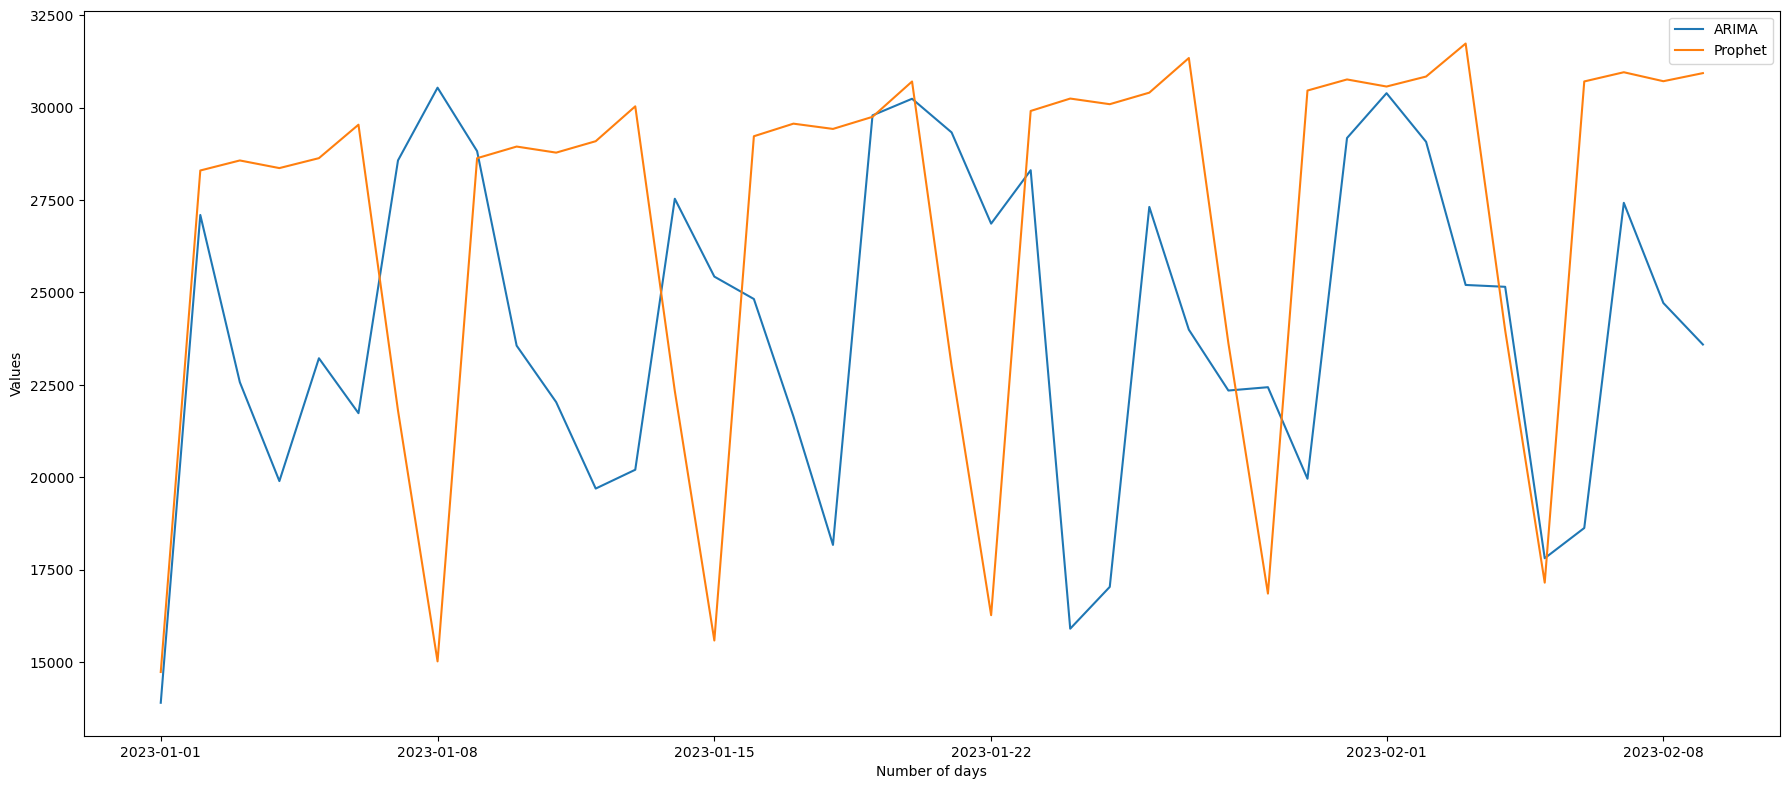

In [79]:
plt.plot(combine_models["predictions_ARIMA"])
plt.plot(combine_models["predictions_Prophet"])
plt.xlabel('Number of days')
plt.ylabel('Values')
plt.legend(["ARIMA", "Prophet"])
plt.tight_layout()

## From graph one can see that both models have similar trends, but the local minimums and maximums are not equally fit in each ranges. Overall ARIMA model seems to be working reasonably well considering the fact that COVID period had an impact on the overall values. Therefore, ARIMA is not able to capture those irregularities